## Constructing a riskless yield curve for Euro
The first thing we need to do to price any option on an equity priced in Euro is construct the so-called riskless yield curve for Euro. This is because pricing of derivatives is done in _the risk-neutral world_ where all investors are assumed not to require a premium for additional risks, hence future cashflows are discounted using the riskless rate to obtain the NPV of the cashflow.

I use [the Euro area yield curve constructed daily by the ECB](https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/html/index.en.html) as proxies for riskless rates. These rates are derived from AAA-rated government bonds of the Euro area. Ideally, using swap rates might be better as government bond yields tend to be 3-4 basis points lower given that government bonds tend to be heavily used in repo trades. See the [this note from the ECB](https://www.ecb.europa.eu/pub/pdf/scpsps/ecb.sps27.en.pdf) for an explanation.

I use the following dataseries provided by the [Eurostat](https://ec.europa.eu/eurostat/web/main/data/database):
* `irt_euryld_d` &mdash; Euro yield curves (daily frequency). This series returns a dataset from which multiple yields can be extracted for maturities ranging from 3 months to 30 years: Instantaneous forward yield curve, Par yield curve, and Spot rate yield curve. For pricing options I use the Spot rate yield curve. The returned rates are presented using Annual percentage rates/yields and represent the average over a given business day. 

And one dataset from [FRED](https://fred.stlouisfed.org):
* `ECBDFR` &mdash; ECB Deposit Facility Rate for Euro Area (daily frequency). I use it as proxy for overnight rate.

I construct the Euro riskfree curve using 40 curve points with the following terms (which is pretty good for accurate pricing):
* Overnight rate from the `ECBDFR` ECB Deposit Facility Rate for Euro Area series (adjusted for the actual/actual day count convention)
* 3-, 4-, 5-, 6-, 7-, 8-, 9-, 10-, 11-months spot rate from the `irt_euryld_d` Euro yield curve series
* 1-, 2-, 3-, ..., 29-, 30-years spot rate from the `irt_euryld_d` Euro yield curve series

In the `pricing.curves.YieldCurve` class I use cubic splines by default to interpolate when constructing the curve. See [this article](http://web.math.ku.dk/~rolf/HaganWest.pdf) for more details on interpolation methods if you want to know more. Cubic splines is pretty advanced.

In [1]:
# Uncomment if running in Google Colaboratory, otherwise the import of the curves module in the cell below will fail
#!git clone -l -s https://github.com/ilchen/options-pricing.git cloned-repo
#%cd cloned-repo

# Install the latest version of pandas-datareader and eurostat libraries
#!pip install pandas-datareader -U
#!pip install eurostat -U

In [2]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import pandas_datareader.data as web
from pandas.tseries.offsets import MonthBegin, BDay

import eurostat

from datetime import date
import re

from dateutil.relativedelta import relativedelta

from volatility import parameter_estimators, volatility_trackers
from pricing import curves, options

In [3]:
today = date.today()

# The ECB provides yields for maturities ranging from 3 months till 30 years
month_maturities = range(3, 12)
year_maturities = range(1, 31)
maturities = ['M'+str(maturity) for maturity in month_maturities]
maturities.extend(['Y'+str(maturity) for maturity in year_maturities])

# Taking the last 3 business days, and converting to decimal fractions
euro_curves = eurostat.get_data_df('irt_euryld_d', filter_pars={
    'startPeriod': (today-BDay(3)).date(), 'freq': 'D',
    'yld_curv': 'SPOT_RT',
    'maturity': maturities,
    'bonds': 'CGB_EA_AAA', 'geo': 'EA'})
euro_curves = euro_curves.drop(euro_curves.columns[:2].append(euro_curves.columns[3:5]), axis=1)
euro_curves = euro_curves.set_index(euro_curves.columns[0]).T / 100.
euro_spot_rates = euro_curves.set_axis(pd.DatetimeIndex(euro_curves.index, 'B'))

# Taking the last 3 business days, and converting to decimal fractions
ecb_deposit_rate = web.get_data_fred('ECBDFR', start=today-BDay(3)) / 100.

# Make daily frequency explicit
ecb_deposit_rate = ecb_deposit_rate.asfreq('D')

In [4]:
# Converting ECB Deposit rates from actual/360 to actual/actual
leap_year_cond = lambda idx: idx.year % 4 == 0 & ((idx.year % 100 != 0) | (idx.year % 400 == 0))
ecb_deposit_rate[leap_year_cond(ecb_deposit_rate.index)] *= 366. / 360
ecb_deposit_rate[np.invert(leap_year_cond(ecb_deposit_rate.index))] *= 365. / 360

In [5]:
date_now = euro_spot_rates.index[-1].date()
offsets = [relativedelta(months=+maturity) for maturity in month_maturities]
offsets.extend([relativedelta(years=+maturity) for maturity in year_maturities])
offsets = [relativedelta()] + offsets

In [6]:
# Define the riskless yield curve for Euro
curve = curves.YieldCurve(today, offsets,
        np.append(
            ecb_deposit_rate.loc[euro_spot_rates.index[-1]].to_numpy(),
            euro_spot_rates.iloc[-1].to_numpy()),
        compounding_freq=1)

### Optional: Visualizing the riskless yield curve for Euro

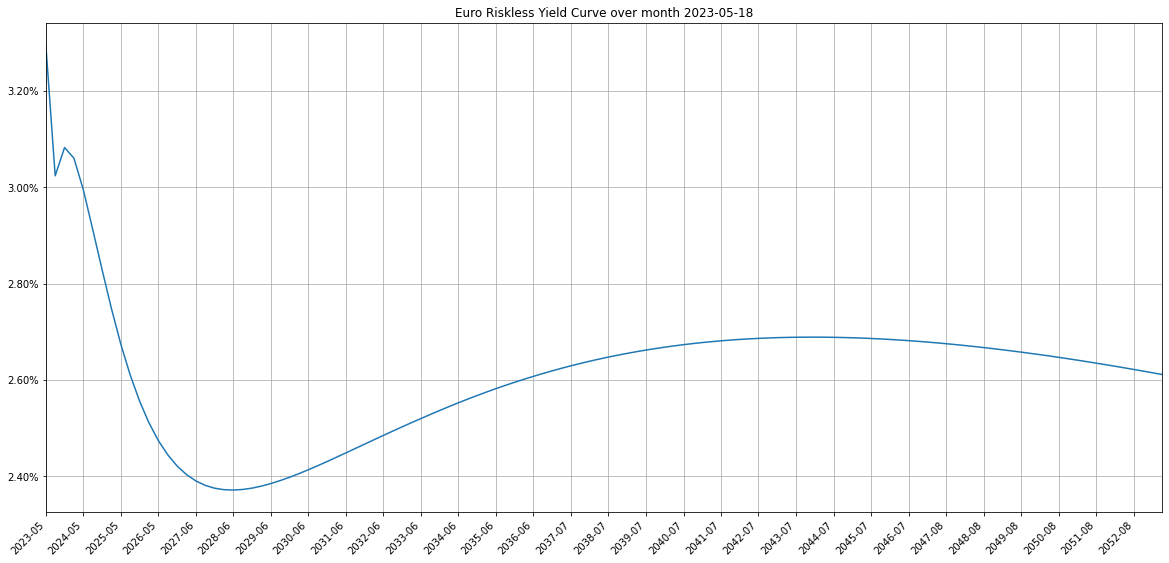

In [7]:
curve_points = curve.get_curve_points(120)
ax = curve_points.plot(figsize=(20,10), grid=True,
                       title='Euro Riskless Yield Curve over month ' + euro_spot_rates.index[-1].strftime('%Y-%m-%d'),
                       xlim=(curve_points.index[0], curve_points.index[-1]),
                       xticks=curve_points.index[::4], xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map(lambda x: x.strftime('%Y-%m'), curve_points.index[::4])))